# 从零开始实现线性回归

算法步骤如下所示：  
>(1)定义模型，初始化模型参数的值，如随机初始化；  
>(2)定义损失函数，用于更新模型参数；  
>(3)从数据集中随机抽取小批量样本，带入定义的模型计算出预测的labels；  
>(4)在损失函数的负梯度的方向上更新模型参数，并不断迭代(3)(4)步骤；随机梯度下降具体公式如下：  
>$$(\bold{w}, b)\leftarrow-\frac{\eta}{\mathcal{|B|}}\sum_{i\in\mathcal{|B|}}\partial_{(\bold w, b)}l^{(i)}(\bold w, b)$$  
> $\eta$为学习率，$\mathcal{|B|}$为一个批量的样本数。  

本且在负梯度的方向上更新参数，并不断迭代这一步骤。
为了简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。我们将使用低维数据，这样可以很容易地将其可视化。在下面的代码中，我们生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。我们的合成数据集是一个矩阵$\bold{X}\in\mathbb{R}^{1000\times2}$。  
我们使用线性模型参数$\bold{w}=[2,-3.4]^\top$、$b=4.2$和噪声项ϵ生成数据集及其标签：  
$$\bold{y}=\bold{Xw}+b+\epsilon$$  
ϵ可以视为模型预测和标签时的潜在观测误差。在这里我们认为标准假设成立，即ϵ服从均值为0的正态分布。为了简化问题，我们将标准差设为0.01。下面的代码生成合成数据集。  

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 1. 生成数据集

In [108]:
def syntheic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    
    # X~N(0, 1),维度:2,(num_examples, len(w))
    X = torch.normal(0, 1, (num_examples, len(w)))
    # y的维度:2, (len(w), 1)
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

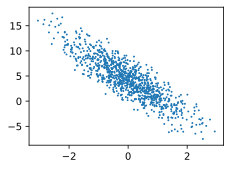

In [118]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2

# 生成数据集
features, labels = syntheic_data(true_w, true_b, 1000)

# 生成第二个特征features[:, 1]和labels的散点图，
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

### 2. 读取数据集

每次抽取一小批量样本，并使用它们来更新我们的模型。由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，该函数能打乱数据集中的样本并以小批量方式获取数据。

In [119]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    # list()和[]的区别
    indices = list(range(num_examples))
    # 打乱indices顺序
    random.shuffle(indices)
    # 构造生成器，生成的小批量样本维度也是2维
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


### 3. 定义模型  

In [120]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b # 注意预测值的维度是1维

### 4. 初始化模型参数

在我们开始用小批量随机梯度下降优化我们的模型参数之前，我们需要先有一些参数。在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。

In [121]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 5. 定义损失函数  

In [122]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 # y_hat是1维（batch_size），y是2维(batch_size, 1)，满足广播机制但得到的是二维(batch_size, batch_size)，因此需要对y的形状进行修改

### 6. 定义优化算法  

In [123]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 7. 训练  

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的训练过程部分了。***理解这段代码至关重要，因为从事深度学习后，相同的训练过程几乎一遍又一遍地出现。在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。计算完损失后，我们开始反向传播，存储每个参数的梯度。最后，我们调用优化算法sgd来更新模型参数。***  

In [124]:
lr = 0.03
batch_size = 10
num_epoch = 4
net = linreg
loss = squared_loss

In [125]:
for epoch in range(num_epoch): # 迭代周期
    for X, y in data_iter(batch_size, features, labels): # 小批量训练
        l = loss(net(X, w, b), y) # 带入模型计算预测值，再计算损失值，注意返回值是1维向量
        l.sum().backward() # 反向传播
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss{float(train_l.mean()):f}')

print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

epoch 1, loss0.025727
epoch 2, loss0.000094
epoch 3, loss0.000053
epoch 4, loss0.000052
w的估计误差：tensor([-7.6771e-05,  5.9128e-04], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0003], grad_fn=<RsubBackward1>)


In [4]:
a = torch.arange(3.)
#print(a, a.shape)
b = torch.ones((3, 3))
#print(b, b.shape)
c = torch.zeros(5)
#print(c, c.shape)
d = torch.arange(0, 10, dtype=torch.float32).reshape(-1, 1)
e = torch.arange(10, dtype=torch.float32)
print(d, d.shape)
print(e, e.shape)
print(e - d, (e - d).shape)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]]) torch.Size([10, 1])
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]) torch.Size([10])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
        [-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [-3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.],
        [-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
        [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
        [-6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.],
        [-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.],
        [-8., -7., -6., -5., -4., -3., -2., -1.,  0.,  1.],
        [-9., -8., -7., -6., -5., -4., -3., -2., -1.,  0.]]) torch.Size([10, 10])


### 8. 要点  
- 时刻关注关键变量：features, labels, 小批量fetaures, 小批量labels, 预测labels的维度。  
- 关注几个超参数：学习率，batchsize，迭代周期epoch。
- 关注三个模块：模型，损失函数，优化算法，确定这三个模块才能对模型进行训练。